In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.sparse import csr_matrix
from scipy.stats import hypergeom
import networkx as nx
import ot

In [ ]:
import liana as li
from liana.method import cellphonedb

In [ ]:
from data import load_data
from deconv import dec_byot
from transport import *
from analysis import *
from interactions import *

In [4]:
data_df = pd.DataFrame(
    {
        'path': ['../', '../', '../', '../data/synthetic/', '../store/oliver/', '../store/oliver/', '../store/oliver/'],
        'most_common': [
            ['T cell lineage', 'Airway epithelium', 'Mast cells'],
            [],
            ['Fibroblasts', '2_Smooth muscle'],
            None, None, None, None
        ],
        'most_common_rec': [
            ['Macrophages', 'Fibroblasts', 'AT2'],
            [],
            ['T cell lineage', 'Mast cells'],
            None, None, None, None
        ]
    }, 
    index = ['paired_ul', 'paired_ll', 'ipf_lung', 'synthetic', 'simu_spatial', 'oliver_simu', 'simu_spatial_rare']
)

In [9]:
data = 'simu_spatial'

In [ ]:
sc_adata, st_adata = load_data(data=data, path=data_df.loc[data, 'path'])
# sc_adata.var_names_make_unique()
# st_adata.var_names_make_unique()
sc_adata.X = sc_adata.X.todense() if isinstance(sc_adata.X, csr_matrix) else sc_adata.X
st_adata.X = st_adata.X.todense() if isinstance(st_adata.X, csr_matrix) else st_adata.X
sc_adata.X = np.asarray(sc_adata.X) if isinstance(sc_adata.X, np.matrix) else sc_adata.X
st_adata.X = np.asarray(st_adata.X) if isinstance(st_adata.X, np.matrix) else st_adata.X

# preprocess
sc_adata.layers["counts"] = sc_adata.X.copy()
sc.pp.normalize_per_cell(sc_adata)
num_cells, num_genes = sc_adata.shape
num_locations = st_adata.shape[0]

In [ ]:
M_init = ot.dist(st_adata.X, sc_adata.X, metric='cosine') # spots by cells

p = ot.unif(num_cells)
q = ot.unif(num_locations)

# epsilon = 5e-3
# T = ot.sinkhorn2(p, q, M_init.T, epsilon)
# # T = (T.T/T.T.sum(0)).T

epsilons = [1e-3, 5e-3, 1e-2, 5e-2]  # List of epsilon values to try

T_list = []  # List to store pairs of epsilon and corresponding T matrices

for epsilon in epsilons:
    T = ot.sinkhorn2(p, q, M_init.T, epsilon)
    T_list.append((epsilon, T))

In [6]:
rec = True if data == 'ipf_lung' else False

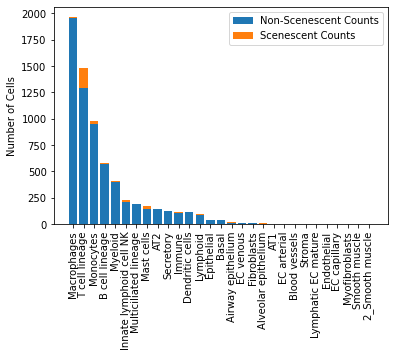

In [7]:
# Load the list of marker genes
senescent_gene_list = ['AREG', 'B2M', 'BEX3', 'CALR', 'CAVIN1', 'CCL2', 'CCL3', 'CCL4', 'CCN2', 'CCND1', 'CD44', 'CD55', 'CD9', 'CITED2', 'COL1A2', 'CREG1', 'CSF1', 'CTSB', 'CXCL1', 'CXCL12', 'CXCL14', 'CXCL2', 'CXCL3', 'CXCL8', 'ECRG4', 'EDN1', 'EHF', 'ERRFI1', 'ETS2', 'F3', 'FILIP1L', 'FN1', 'FOS', 'GNG11', 'GSN', 'HMGB1', 'HSPA2', 'ID1', 'ID2', 'IFI16', 'IGFBP4', 'IGFBP5', 'IGFBP7', 'IL32', 'ISG15', 'JUN', 'LMNA', 'MCL1', 'MMP10', 'MMP2', 'NDN', 'NME2', 'NTN4', 'PEBP1', 'PKM', 'PLAUR', 'RAC1', 'RHOB', 'S100A11', 'SFN', 'SGK1', 'SOD1', 'SPARC', 'TGFB1I1', 'TMSB4X', 'TNFRSF1B', 'TXNIP', 'VIM', 'ZFP36']

most_common = data_df.loc[data, 'most_common']
most_common_rec = data_df.loc[data, 'most_common_rec'] if rec else None
senescent_cells, senescent_counts = senescence(data, sc_adata, senescent_gene_list)
senescent_cells_rec, senescent_counts_rec = senescence(data, sc_adata, senescent_gene_list, rec=rec) if rec else (None, None)
sc_adata = reannotate(sc_adata, most_common, senescent_cells, most_common_rec, senescent_cells_rec)

save = None
pl_senesence(sc_adata, senescent_cells, senescent_cells_rec, most_common_rec, save=save)

/ocean/projects/hmcmutc/namn/sennet/code/deconv.py:157: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


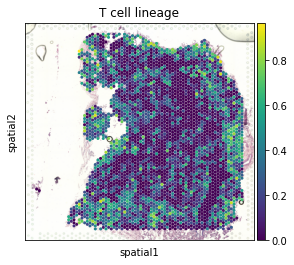

In [8]:
st_adata = dec_byot(sc_adata, st_adata, 'annotations', T)
    
for ct in st_adata.obsm["deconvolution"].columns:
# for ct in ['T cell lineage']:
    sc.pl.spatial(
    st_adata, 
    img_key = "hires", 
    color = [ct], 
    size = 1.5, 
    # save = ct + '_ll.pdf',
    # color_map = 'inferno'
    )

/jet/home/namn/.conda/envs/sc/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


  0%|          | 0/1000 [00:00<?, ?/s]

/jet/home/namn/.conda/envs/sc/lib/python3.10/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
/jet/home/namn/.conda/envs/sc/lib/python3.10/site-packages/matplotlib/colors.py:1306: UserWarning: Warning: converting a masked element to nan.


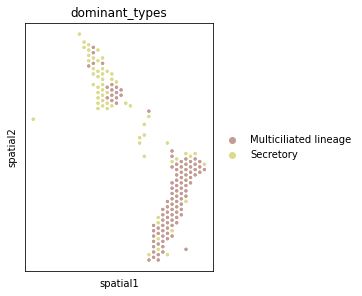

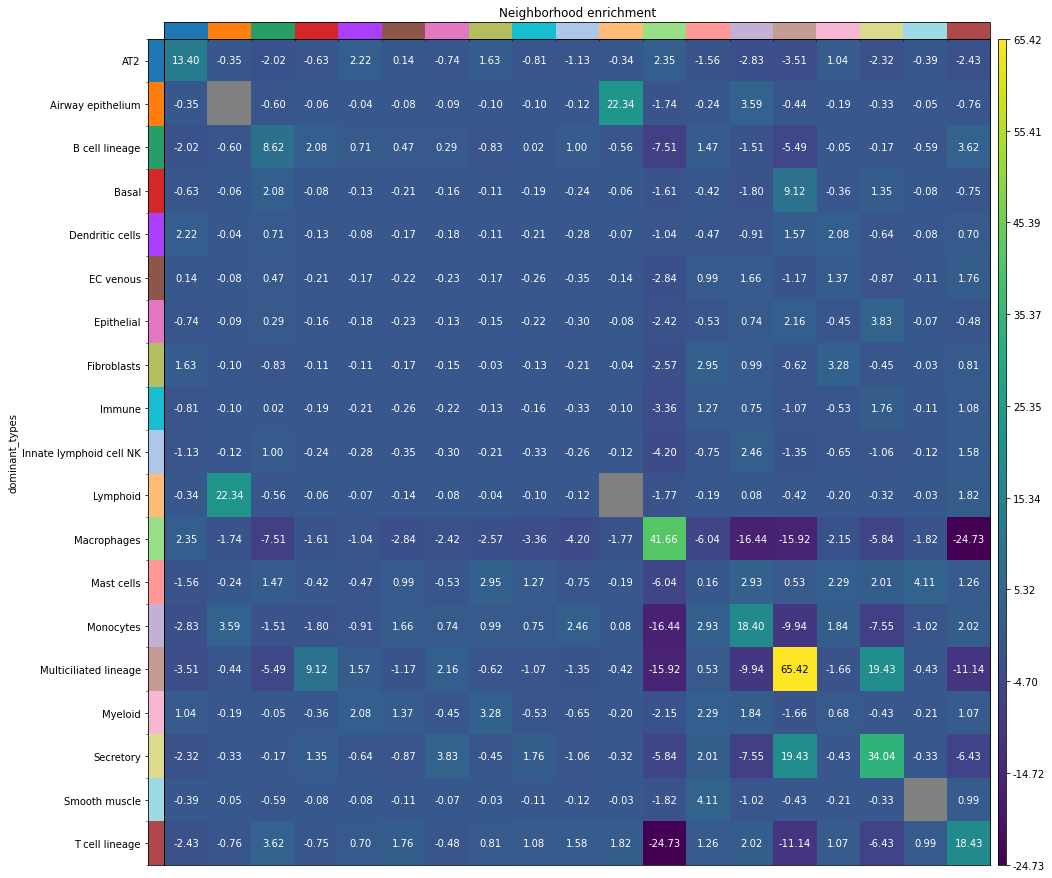

In [9]:
import squidpy as sq

deconvolution_df = pd.DataFrame(st_adata.obsm['deconvolution'])
# Find the column index with the maximum value for each row
max_proportion = deconvolution_df.idxmax(axis=1)
st_adata.obs['dominant_types'] = max_proportion.astype('category')

sq.pl.spatial_scatter(
    st_adata, color="dominant_types", size=20, shape=None, 
    groups=[
        'Multiciliated lineage', 'Secretory'
    ], 
    # save=''
)
sq.gr.spatial_neighbors(st_adata)
sq.gr.nhood_enrichment(st_adata, cluster_key="dominant_types")
sq.pl.nhood_enrichment(
    st_adata, cluster_key="dominant_types", annotate=True,
    # save=''
)

In [ ]:
# coupling = T
# k = 10
# save = None
# cell_adj = cell_graph(sc_adata, st_adata, coupling, k=k, save=save)

loaded_graph = '../store/cell_graph.npy' # unpaired data
# loaded_graph = 'cell_graph_ul.npy' # paired UL data
cell_adj = np.load(loaded_graph)

annotations = 'annotations_updated'
# Create a dictionary to map node IDs to their annotation types
node_annotations = sc_adata.obs.reset_index().loc[
    [i for i in range(cell_adj.shape[0])], 
    annotations
].to_dict()

In [ ]:
import sys
sys.path.append("ManifoldWarping/python")
from neighborhood import neighbor_graph

X = np.asarray(sc_adata.X)
Wx = neighbor_graph(X,k=10)

Wx = Wx.astype(int)
cell_adj = cell_adj.astype(int)

# Calculate the number of overlapping edges
overlapping_edges = np.count_nonzero(np.logical_and(Wx, cell_adj))
# Calculate the number of total edges in each graph
edges_Wx = np.count_nonzero(Wx)
edges_cell_adj = np.count_nonzero(cell_adj)
# Calculate the union of edges
union_edges = edges_Wx + edges_cell_adj - overlapping_edges
# Calculate the ratio of edges attributed to expression similarity
r = overlapping_edges / edges_cell_adj
# Calculate the Jaccard index
J = overlapping_edges / union_edges

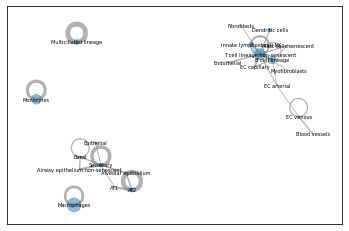

In [12]:
adj = cell_adj
node_annotations = node_annotations
loaded_table = None
save_table = None
nodes_of_interest = None
weight_threshold = 0.15
layout = 'spring'
save_plot = None

df = type_table(
    adj, 
    node_annotations, 
    loaded_table, 
    save_table, 
    nodes_of_interest, 
    weight_threshold, 
    layout, 
    save_plot
)

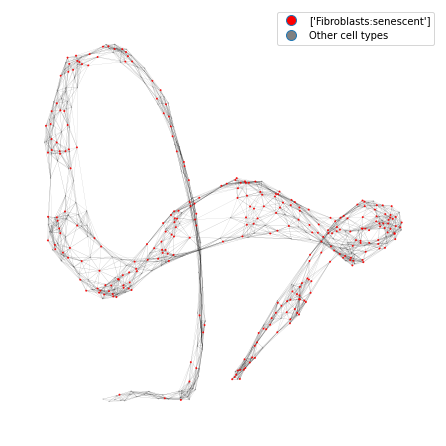

In [15]:
adj = cell_adj
subgraph = None
node_annotations = node_annotations
desired_category = ['Fibroblasts:senescent']
n_sizes = [1, 0.1]
n_alphas = [0.8, 0.5]
clrmap = 'binary'
save_graph = None
save_plot = 'sen_graph_ipf_fib.pdf'

sen_graph = neigh_of_interest(adj, subgraph, node_annotations, desired_category, n_sizes, n_alphas, clrmap, save_graph, save_plot)

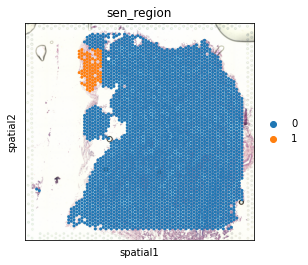

In [10]:
# Define the region of interest
xmin = 3000
xmax = 4900
ymin = 1750
ymax = 4000
# Create a boolean mask to select the cells or spots within the region of interest
mask = (st_adata.obsm["spatial"][:, 0] >= xmin) & (st_adata.obsm["spatial"][:, 0] <= xmax) & (st_adata.obsm["spatial"][:, 1] >= ymin) & (st_adata.obsm["spatial"][:, 1] <= ymax)
# Use the boolean mask to subset your data to only include the cells or spots within the region of interest
st_adata.obs['sen_region'] = mask
st_adata.obs['sen_region'] = st_adata.obs['sen_region'].astype(int).astype('category')

sc.pl.spatial(
    st_adata, 
    img_key = "hires", 
    color = 'sen_region', 
    size = 1.5, 
    # save = '',
    color_map = 'inferno'
    )

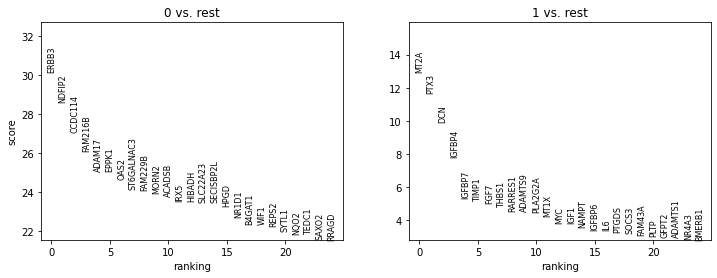

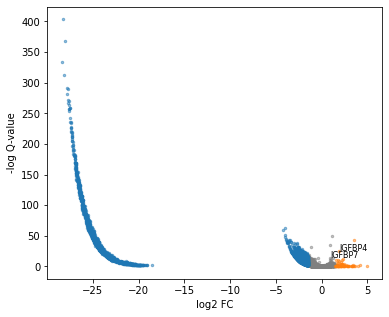

In [11]:
sc.tl.rank_genes_groups(st_adata, 'sen_region', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(st_adata, n_genes=25, sharey=False, key = "t-test")
result = sc.get.rank_genes_groups_df(st_adata, group='1', key='t-test').copy()

FDR = 0.01
LOG_FOLD_CHANGE = 1.5
gene_names_to_show = ['IGFBP4', 'IGFBP7']
save = None
pl_volcano(result, FDR, LOG_FOLD_CHANGE, gene_names_to_show, save)

In [12]:
sen_big_list = ['0', 'AAK1', 'ABI3', 'ABL1', 'ACVR1B', 'ADCK5', 'AKR1B1', 'AKT1', 'AKT3', 'ALDH1A3', 'ALOX15B', 'ANG', 'ANGPT1', 'ANGPTL4', 'AOPEP', 'AR', 'AREG', 'ARG2', 'ARNTL', 'ARPC1B', 'ASF1A', 'ATM', 'AXL', 'B2M', 'BCL6', 'BEX3', 'BHLHE40', 'BMI1', 'BMP2', 'BMPR1A', 'BRAF', 'C3', 'CALR', 'CAVIN1', 'CBX7', 'CBX8', 'CCL13', 'CCL2', 'CCL20', 'CCL3','CCL3L1','CCL4','CCL5','CCL7','CCN2','CCND1','CD44','CD55','CD9','CDK18','CDK2','CDK4','CDK6','CDKN1A','CDKN1B','CDKN1C','CDKN2A','CDKN2AIP','CDKN2B','CDKN2D','CEBPB','CGAS','CITED2','CKB','CLTB','COL1A2','CREG1','CRYAB','CSF1','CSF2RB','CTNNB1','CTSB','CXCL1','CXCL10','CXCL12','CXCL14','CXCL16','CXCL2','CXCL3','CXCL8','CYP1B1','DEK', 'DKK1', 'ECRG4', 'EDN1', 'EEF1E1', 'EGFR', 'EHF', 'EIF2S2', 'EREG', 'ERRFI1', 'ETS1', 'ETS2', 'F3', 'FAS', 'FASTK', 'FBXO31', 'FBXO5', 'FGF7','FILIP1L', 'FN1', 'FOS', 'FXR1', 'GDF15', 'GEM', 'GMFG', 'GNG11', 'GRK6', 'GSN', 'GUK1', 'H2AX', 'HBS1L', 'HDAC1', 'HDAC4', 'HGF', 'HK3', 'HLA-G', 'HMGA1', 'HMGB1', 'HPS5', 'HRAS', 'HSPA2', 'HSPA5', 'HTATIP2', 'ICAM1', 'ICAM3', 'ID1', 'ID2', 'ID4', 'IFI16', 'IFNG', 'IGF1', 'IGF1R', 'IGFBP2', 'IGFBP3', 'IGFBP4', 'IGFBP5', 'IGFBP6', 'IGFBP7', 'IGSF3', 'IL10', 'IL15', 'IL18', 'IL1A', 'IL1B', 'IL32', 'IL6', 'IL6ST', 'IL7', 'ING1', 'ING2', 'IQGAP2', 'IRF3', 'IRF5', 'IRF7', 'ISG15', 'ITGA2', 'ITPK1', 'ITPKB', 'ITSN2', 'JUN', 'KAT5', 'KAT6A', 'KIR2DL4', 'KITLG', 'LCP1', 'LIMK1', 'LMNA', 'MAP1LC3B', 'MAP2K1', 'MAP2K2', 'MAP2K3', 'MAP2K4', 'MAP2K6', 'MAP2K7', 'MAP3K3', 'MAP3K5', 'MAP3K6', 'MAP3K7', 'MAPK10', 'MAPK11', 'MAPK14', 'MAPK8', 'MAPK9', 'MAPKAPK5', 'MATK', 'MCL1','MCRS1', 'MDM2', 'MIF', 'MMP1', 'MMP10', 'MMP13', 'MMP14', 'MMP2', 'MMP3', 'MMP9', 'MOB3A', 'MORC3', 'MVK', 'MXD4','NADK', 'NAP1L4', 'NDN', 'NEK4', 'NEK6', 'NINJ1', 'NME2', 'NPM1', 'NRG1', 'NSMCE2', 'NTN4', 'NUAK1', 'OPA1', 'OPTN','PAK4', 'PATZ1', 'PAWR', 'PCGF2', 'PDIK1L', 'PDPK1', 'PDZD2', 'PEA15', 'PEBP1', 'PECAM1', 'PEX19', 'PGF', 'PIAS4','PIGF', 'PIK3R5', 'PIM1', 'PKM', 'PLA2R1', 'PLAT', 'PLAU', 'PLAUR', 'PLK2', 'PML', 'PMVK', 'PNPT1', 'PPM1D', 'PRKCD','PRKCH', 'PRMT6', 'PROX1', 'PRPF19', 'PSMB5', 'PTBP1', 'PTGER2', 'PTGES', 'PTTG1', 'RAB13', 'RAB31', 'RAB5B', 'RABGGTA','RAC1', 'RAF1', 'RBL1', 'RBL2', 'RGL2', 'RHOB', 'RNASEL', 'RPS6KA5', 'RRAS', 'RSL1D1', 'RUNX1', 'S100A11', 'SCAMP4','SELPLG', 'SEMA3F', 'SERPINB2', 'SERPINB4', 'SERPINE1', 'SERPINE2', 'SFN', 'SGK1', 'SIK1', 'SIN3B', 'SIRT1', 'SLC13A3','SMARCB1', 'SMC5', 'SMC6', 'SMPD1', 'SMURF2', 'SOCS1', 'SOD1', 'SORBS2', 'SOX2', 'SOX5', 'SP1', 'SPARC', 'SPI1', 'SPIN1','SPOP', 'SPP1', 'SRC', 'SREBF1', 'SRF', 'SRSF1', 'STAT1', 'STAT5B', 'STK32C', 'STK40', 'SYK', 'TBX2', 'TBX3', 'TERF2','TES', 'TFAP2A', 'TFAP4', 'TGFB1I1', 'THBS1', 'TIMP2', 'TLR3', 'TMSB4X', 'TNF', 'TNFAIP2', 'TNFAIP3', 'TNFRSF10C', 'TNFRSF1A', 'TNFRSF1B', 'TNFSF15', 'TP53', 'TSPYL5', 'TUBGCP2', 'TXNIP', 'TYK2', 'UBTD1','ULK3', 'VASH1', 'VEGFA', 'VEGFC', 'VIM', 'WRN', 'WWP1', 'XAF1', 'YBX1', 'YPEL3', 'ZFP36', 'ZMPSTE24', 'ZNF277']

['IGFBP4;IGFBP7;FGF7;THBS1;IGF1;IGFBP6;IL6;SERPINE2;PIM1;ALDH1A3;SERPINE1;COL1A2;ANGPTL4;CYP1B1;PLAU']

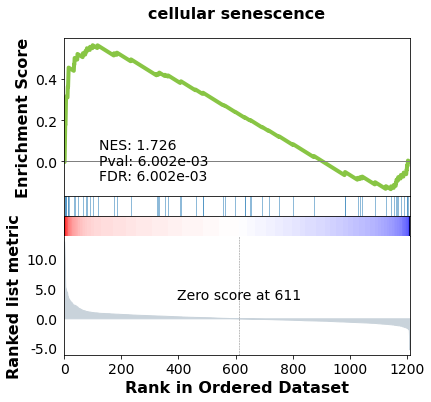

In [13]:
import gseapy

res = gseapy.prerank(
    rnk=result[result['logfoldchanges']>-.51][['names', 'scores']], 
    gene_sets={'cellular senescence': sen_big_list}
)
terms = res.res2d.Term
gseapy.gseaplot(rank_metric=res.ranking, 
                term=terms[0], 
                **res.results[terms[0]], 
                # ofname=''
               )

res.res2d['Lead_genes'].tolist()

In [20]:
coupling = T
region = st_adata.obs['sen_region'].astype(int).values
adj = cell_adj
subgraph = sen_graph

sen_graph_in_region = cell_in_region(coupling, region, adj, subgraph)

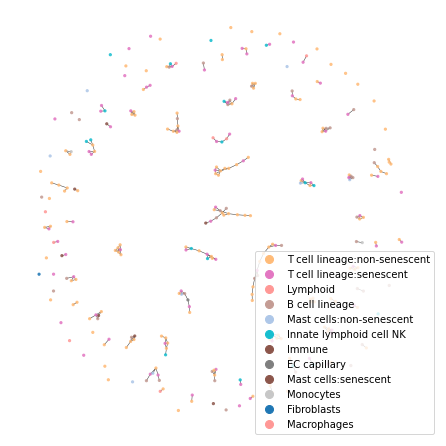

In [21]:
adj = None
subgraph = sen_graph_in_region
node_annotations = node_annotations
desired_category = None
n_sizes = 5
n_alphas = 0.8
clrmap = 'tab20'
save_graph = None
save_plot = None

neigh_of_interest(adj, subgraph, node_annotations, desired_category, n_sizes, n_alphas, clrmap, save_graph, save_plot)

Using `.raw`!
5023 features of mat are empty, they will be removed.
The following cell identities were excluded: EC capillary, Fibroblasts, Macrophages, Mast cells:senescent, Monocytes


/jet/home/namn/.conda/envs/sc/lib/python3.10/site-packages/pandas/core/indexing.py:1761: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.64 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 298 samples and 11773 features


100%|██████████| 1000/1000 [00:02<00:00, 370.12it/s]
/jet/home/namn/.conda/envs/sc/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


0.007680550486656494

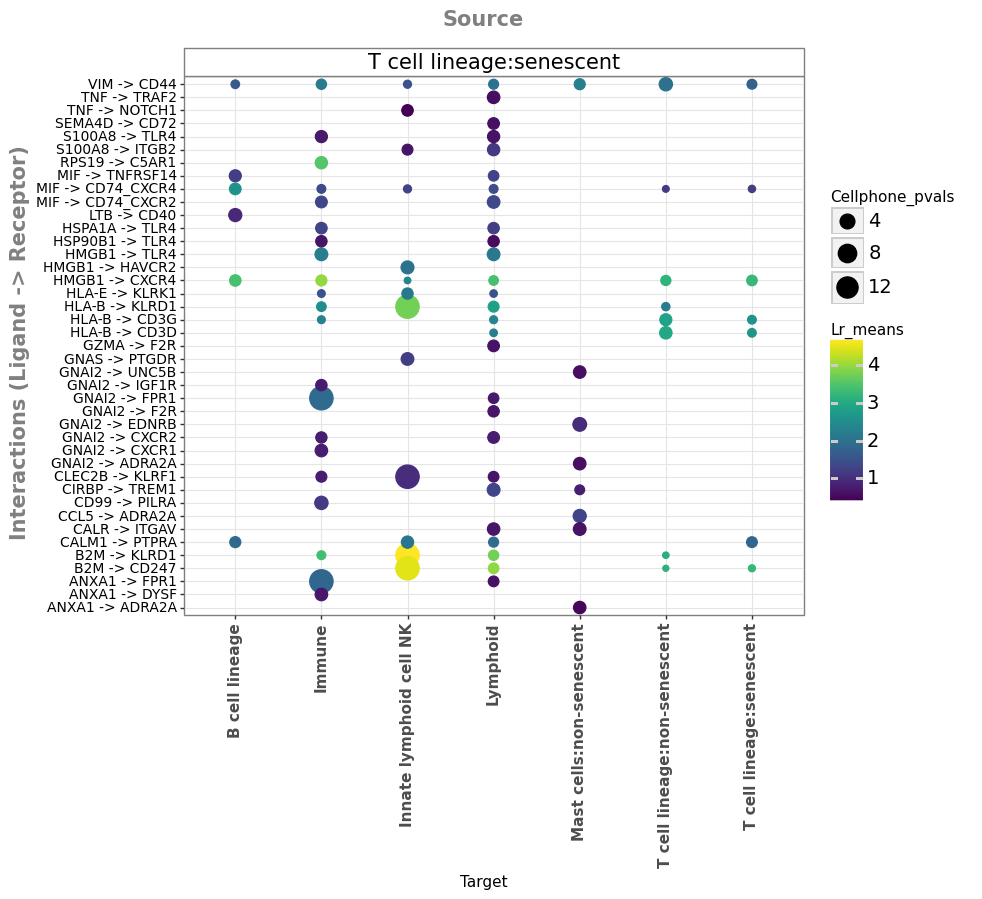

In [22]:
annotations = 'annotations_updated'
source_labels = 'T cell lineage:senescent'
target_labels = 'T cell lineage:senescent'

sc_adata_subset = sc_adata[list(sen_graph_in_region.nodes())]
cellphonedb(
    sc_adata_subset, 
    groupby=annotations, 
    expr_prop=0.1, 
    verbose=True, 
    key_added='cpdb_res'
)
p = li.pl.dotplot(adata = sc_adata_subset,
              colour='lr_means',
              size='cellphone_pvals',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=source_labels,
              # target_labels=target_labels,
              figure_size=(8, 7),
              # finally, since cpdbv2 suggests using a filter to FPs
              # we filter the pvals column to <= 0.05
              filterby='cellphone_pvals',
              filter_lambda=lambda x: x <= 0.05,
              uns_key='cpdb_res' # uns_key to use, default is 'liana_res'
             )
# p.save('')
p.draw()

subset_df = sc_adata_subset.uns['cpdb_res']
filtered_df = subset_df[
    (subset_df['cellphone_pvals'] < 0.05) & 
    (subset_df['source'] == 'T cell lineage:senescent') |
    (subset_df['target'] == 'T cell lineage:senescent')
]
unique_ligands = filtered_df['ligand'].unique()
unique_receptors = filtered_df['receptor'].unique()

lr_set = set(np.unique(list(unique_ligands) + list(unique_receptors)))

all_genes = set(sc_adata_subset.var_names.tolist()).union(set(sen_big_list)).union(lr_set)
sen_genes = set(sen_big_list)#.intersection(all_genes)
lr_genes = lr_set#.intersection(all_genes)

# Define the sizes of the sets
N = len(all_genes)  # Total number of all genes
n = len(sen_genes)  # Total number of marker genes
M = len(lr_genes)  # Number of ligand-receptor genes

# Calculate the number of overlapping genes
x = len(sen_genes.intersection(lr_genes))  # Number of marker genes found in expressed ligand-receptor genes

# Perform hypergeometric test
p_value = hypergeom.sf(x - 1, N, n, M)
p_value